In [1]:
import os.path
import numpy as np
import scipy as sp
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 16
CFL = np.sqrt(0.5)
t = 0.31

L = 1
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5]
locs = [0.5]

func = WFT.Gauss






N = nh_min

In [3]:
omega = BT.Grid(nh_min)
physics = BT.PhysProps(omega, epsilons, mus, locs, L)

In [4]:
## Calculate the RHS for E,B in Maxwell's equations using 1st-order upwind
def calcRHSUpwind1(E, B, c1, c2, N, dx):

    # Transform to the computational vars w/ eigen xform
    ix1 = np.arange(int(N/2))
    phil1 = .5*(E[ix1]-c1*B[ix1])
    phir1 = .5*(E[ix1]+c1*B[ix1])
    ix2 = np.arange(int(N/2))+int(N/2)
    phil2 = .5*(E[ix2]-c2*B[ix2])
    phir2 = .5*(E[ix2]+c2*B[ix2])

    # Face values from upwind (index 1:N for faces left of cell + 1 for mat)
    phil1f = np.append(phil1, 0) # 0 placeholder for value with jump condition
    phir1f = np.append(0, phir1) # 0 at leftmost face for boundary conditions
    phil2f = np.append(phil2, 0) # 0 at rightmost face for boundary conditions
    phir2f = np.append(0, phir2)
    # Correct values at material interface with jump conditions
    ix = int(N/2)
    T1 = 2*c1/(c1+c2)
    R1 = (c2-c1)/(c1+c2)
    phil1f[ix] = T1*phil2f[0] + R1*phir1f[ix]
    T2 = 2*c2/(c1+c2)
    R2 = (c1-c2)/(c1+c2)
    phir2f[0] = R2*phil2f[0] + T2*phir1f[ix]

    # Transform back to E,B on faces
    E1f = phil1f + phir1f
    B1f = (-phil1f + phir1f)/c1
    E2f = phil2f + phir2f
    B2f = (-phil2f + phir2f)/c2

    # Calculate the RHS for E, B
    ixf = np.arange(int(N/2))+1
    rhsE = np.append(-c1**2*(B1f[ixf] - B1f[ixf-1])/dx, -c2**2*(B2f[ixf] - B2f[ixf-1])/dx)
    rhsB = np.append(-1*(E1f[ixf] - E1f[ixf-1])/dx, -1*(E2f[ixf] - E2f[ixf-1])/dx)
    return rhsE, rhsB

In [5]:
## Calculate the RHS for E,B in Maxwell's equations using 5th-order upwind
def calcRHSUpwind5(E, B, c1, c2, N, dx):
    # Fill in ghost cells for left, right domain - need 3 for up5
    P = 5  # 5th-order interpolant
    Ng = 3  # 3 ghost cells for this stencil
    Eg1, Eg2 = ghostCellsJump(E, dx, N, Ng, P)
    print('Ghost Cells:')
    print(Eg1)
    print(Eg2)
    print('')
    Bg1, Bg2 = ghostCellsJump(B, dx, N, Ng, P)

    # Transform to the computational vars w/ eigen xform
    ix1 = np.arange(0, N // 2)
    E1 = np.concatenate((E[ix1], Eg1))  # with ghost cell values at the jump
    B1 = np.concatenate((B[ix1], Bg1))
    phil1 = 0.5 * (E1 - c1 * B1)  # characteristic variable
    phir1 = 0.5 * (E1 + c1 * B1)
    ix2 = np.arange(N // 2, N)
    E2 = np.concatenate((Eg2, E[ix2]))  # with ghost cell values at the jump
    B2 = np.concatenate((Bg2, B[ix2]))
    phil2 = 0.5 * (E2 - c2 * B2)
    phir2 = 0.5 * (E2 + c2 * B2)

    # Regular Face stencil from cell-averages - upwind for right-moving
    # [2 -13 47 | 27 -3]/60
    sr = np.array([2, -13, 47, 27, -3]) / 60
    Ni = N // 2 + 2 * Ng  # +3 ghost cells either side
    Ur = sp.sparse.diags(sr, np.arange(0, 5), shape=(N // 2 + 1, Ni))

    sl = np.flip(sr)
    Ul = sp.sparse.diags(sl, np.arange(1, 6), shape=(N // 2 + 1, Ni))

    # Face values from upwind (index 1:N for faces left of cell + 1 for mat)
    phil1f = Ul.dot(np.concatenate((np.full(3, phil1[0]), phil1)))  # outflow bc's on left
    phir1f = Ur.dot(np.concatenate((np.zeros(3), phir1)))  # 0 at leftmost face for inflow boundary conditions
    phil2f = Ul.dot(np.concatenate((phil2, np.zeros(3))))  # 0 at rightmost face for inflow boundary conditions
    phir2f = Ur.dot(np.concatenate((phir2, np.full(3, phir2[N // 2 + Ng - 1]))))  # outflow bc's on right

    # Correct values at material interface with jump conditions
    ix = N // 2
    T1 = 2 * c1 / (c1 + c2)
    R1 = (c2 - c1) / (c1 + c2)
    phil1f[ix] = T1 * phil2f[0] + R1 * phir1f[ix]
    T2 = 2 * c2 / (c1 + c2)
    R2 = (c1 - c2) / (c1 + c2)
    phir2f[0] = R2 * phil2f[0] + T2 * phir1f[ix]

    # Transform back to E,B on faces
    E1f = phil1f + phir1f
    B1f = (-phil1f + phir1f) / c1
    E2f = phil2f + phir2f
    B2f = (-phil2f + phir2f) / c2

    # Calculate the RHS for E, B
    ixf = np.arange(1, N // 2 + 1)
    rhsE = np.concatenate((-c1**2 * (B1f[ixf] - B1f[ixf - 1]) / dx, -c2**2 * (B2f[ixf] - B2f[ixf - 1]) / dx))
    rhsB = np.concatenate((-1 * (E1f[ixf] - E1f[ixf - 1]) / dx, -1 * (E2f[ixf] - E2f[ixf - 1]) / dx))

    return rhsE, rhsB

In [6]:
# RK1 for a given rhs function
def doRK1(E, B, dt, fn_rhs, args):
    N = np.shape(E)[0]
    assert(N == np.shape(B)[0])

    rhsE, rhsB = fn_rhs(E, B, *args)
    E = E + dt*rhsE
    B = B + dt*rhsB
    return E, B

In [7]:
def calcPhiAverage(phi_fn, x, dx, N):

    qloc = np.linspace(0, 1, num = 5)
    qweights = np.asarray([7, 32, 12, 32, 7])/90
    phiavg = np.zeros(N, float)
    for q in range(5):
        phiavg = phiavg + qweights[q]*phi_fn(x[:N]+dx*qloc[q])
    return phiavg

In [8]:
def momentMatrix(x, x0, h, ixs, P):
    ilo = min(ixs)
    ihi = max(ixs)
    xhi = (x[ilo+1:ihi+2] - x0)/h
    xlo = (x[ilo:ihi+1] - x0)/h
#     print('xhi:')
#     print(xhi)
#     print('xlo:')
#     print(xlo)
    A = np.zeros((np.shape(ixs)[0],P), float)
    for p in range(P):
#         print('p:', p)
#         print('A 1:')
#         print((xhi**(p+1))/(p+1))
        A[:,p] = (xhi**(p + 1) - xlo**(p + 1)) / ((p + 1) * (xhi - xlo))
    A = np.asarray(A)
    return A

`P:` $o$ (order of interpolation)
  
`Ng:` $g$ (number of ghost cells)  
  
1. Construct vector of $x$ values at faces with $o$ many cells to the left and $o$-many cells to the right of the material boundary.  
  
`x:` ***x*** $= \begin{bmatrix}x_{s-o} & x_{s-o+1} & ... & x_{s-2} & x_{s-1}& x_{s} & x_{s+1} & x_{s+2} & ... & x_{s+o-1} & x_{s+o}\end{bmatrix}$  
  
2. Construct $2o \times o$ Vandermonde moment matrix from ***x*** boundary values for order $o$ interpolation.  
  
`A:` ***A*** $= \begin{bmatrix}\frac{1}{x_{s-o+1}-x_{s-o}} \int_{x_{s-o}}^{x_{s-o+1}}dx & \frac{1}{x_{s-o+1}-x_{s-o}} \int_{x_{s-o}}^{x_{s-o+1}} x dx & \frac{1}{x_{s-o+1}-x_{s-o}} \int_{x_{s-o}}^{x_{s-o+1}} x^{2} dx & ... & \frac{1}{x_{s-o+1}-x_{s-o}} \int_{x_{s-o}}^{x_{s-o+1}} x^{o - 1} dx& \frac{1}{x_{s-o+1}-x_{s-o}} \int_{x_{s-o}}^{x_{s-o+1}} x^{o} dx
\\ \frac{1}{x_{s-o+2}-x_{s-o+1}} \int_{x_{s-o+1}}^{x_{s-o+2}}dx
\\ ...
\\ \frac{1}{x_{s-1}-x_{s-2}} \int_{x_{s-2}}^{x_{s-1}}dx
\\ \frac{1}{x_{s}-x_{s-1}} \int_{x_{s-1}}^{x_{s}}dx
\\ \frac{1}{x_{s+1}-x_{s}} \int_{x_{s}}^{x_{s+1}}dx
\\ ...
\end{bmatrix}$  
  
3. Create non-square $2o+1 \times 2o$ matrix ***B***, which is block diagonal of top half and bottom half of Vandermonde ***A*** with a row containing 0s, 1, and -1 beneath.  
  
`B:` ***B*** $= \begin{bmatrix} & & \mathbf{A}_{1} & & & & & \mathbf{0} & &
\\
\\ & & \mathbf{0} & & & & & \mathbf{A}_{2} & &
\\
\\ 1 & 0 & 0 & ... & 0 & -1 & 0 & 0 & ... & 0 \end{bmatrix}$
  
4. Multiply the pseudoinverse of matrix B to a vector of $o$-many cell-average values of the solution from both the left and right side of the material interface plus an additional elements 0 at the bottom to get the polynomial function ***p*** for approximating ghost cells in that region.  
  
`phic:` ***p*** $=$ ***B***$^{+} \begin{bmatrix}<u>_{s-o}
\\ <u>_{s-o+1}
\\ ...
\\ <u>_{s-2}
\\ <u>_{s-1}
\\ <u>_{s}
\\ <u>_{s+1}
\\ ...
\\ <u>_{s+o-2}
\\ <u>_{s+o - 1}
\\ 0 \end{bmatrix}$
  
5. Multiply $g$-many rows from the left and $g$-many rows from the right sides of Vandermonde matrix ***A*** with first $o$-many and last $o$-many elements of ***p***, respectively, to get values of ghost cells on left and right side of material boundary.


In [9]:
# Fill in cell-average ghost cells using jump conditions

def ghostCellsJump(phiavg,dx,N,Ng,P):
    # Create the cell average interpolation matrix
    x = np.arange(-P, P + 1).transpose()*dx
#     print('x:')
#     print(x)
    x0 = 0
    ixs = np.arange(2*P).transpose()
#     print('ixs:')
#     print(ixs)
    A = momentMatrix(x,x0,dx,ixs,P)
#     print('Vandermonde:')
#     print(A)
#     print('h 1:')
#     print(1 / dx)
#     garbage1 = GTT.MomentVander(9, x, x[:6])

    # Build up an interpolant using the jump condition
    ix = np.arange(P)
    phi1 = phiavg[int(N/2-P)+ix] # phi avg in domain 1
#     print('phiavg')
#     print(phiavg)
#     print('phi1:')
#     print(phi1)
    ix2 = np.arange(P)+P # domain 2 entries
    phi2 = phiavg[int(N/2-P)+ix2] # phi avg in domain 2
    B = OT.Block([A[ix,:], A[ix2,:]]) # add the fit to the matrix
    addOn = np.zeros(2 * P, float)
    addOn[0] = 1
    addOn[P] = -1
    # Add the jump cond constraint - constant coef is same at x=0
    B = np.vstack([B, addOn])
#     print('B:')
#     print(B)
    # Solve it with LS
    phic = LA.pinv(B)@np.concatenate([phi1, phi2, np.zeros(1, float)])


    # Evaluate the phi1 ghost cell values
    ix = P+np.arange(Ng)
    phig1 = A[ix,:]@phic[:P]
#     print('A after 1:')
#     print(A[ix,:])

    # Evaluate the phi2 ghost cell values
    ix = np.arange(P-Ng, P)
    phig2 = A[ix,:]@phic[P:2*P]
#     print('A after 2:')
#     print(A[ix,:])
#     print('')
    return phig1, phig2

In [10]:
def testGhostCells():
    dx = .01 # grid spacing
    N = 20 # 10 cells each side
    phic1 = np.asarray([1, .5, 2, -.5, -.1]) # Domain 1 test polynomial, HOT on left
    phic2 = np.asarray([-1, 2, -.5, .5, -.1]) # Domain 2 test polynomial
    # Calculate the cell average vector with the ghost cells
    Ng = 3 # 2 ghost cells
    ix = np.asarray(np.arange(N/2+Ng+1), int) # I DON'T KNOW IF YOU NEED THIS LINE AT ALL.
    x = np.arange(-N/2, Ng + 1)*dx
    phiint = np.polyint(phic1)
    ix = np.asarray(np.arange(N/2+Ng) + 1, int)
    phiavg1 = (np.poly1d(phiint)(x[ix]) - np.poly1d(phiint)(x[ix-1])) / dx
    x = -x[::-1]
    phiint = np.polyint(phic2)
    phiavg2 = (np.poly1d(phiint)(x[ix]) - np.poly1d(phiint)(x[ix-1])) / dx
    ix = np.asarray(np.arange(N/2), int)
    phiavg = np.concatenate((phiavg1[ix], phiavg2[ix+Ng])).transpose() # column vector of just interior

    # Call the ghost cell interpolation
    P = 5 # 5th-order interpolant
    phig1, phig2 = ghostCellsJump(phiavg,dx,N,Ng,P)

    # Check the ghost cell values
    tol = 1e-13
    assert(TT.VectorNorm(phiavg1[int(N/2):int(N/2)+Ng] - phig1) < tol)
    assert(TT.VectorNorm(phiavg2[:Ng] - phig2) < tol)
    
    return


In [11]:
degFreed = omega.degFreed
xNode = omega.xNode
xCell = omega.xCell

cs = physics.cVec

In [12]:
c1 = cs[0]
c2 = cs[-1]

t, nt = ST.CalcTime(omega, CFL, max(cs), t = t)
dx, dt = ST.FindDxDt(omega, CFL, max(cs))
nt = 4 # nt + 1 # SASHA VERSION

mu = 0.25
sigma = 1./32.
args = [sigma, mu]

print(nt)

This is what's happening.
4


In [13]:

# waveInit = WFT.InitCond(omega, physics, func, args)
# # Add provision into InitCond to zero out anything below the tolerance.
# testGhostCells()

# waveInit[abs(waveInit) < 1e-15] = 0

# E = waveInit[:degFreed]
# B = waveInit[degFreed:]

phi_fn = lambda x: exp(-((x-mu)/sigma)**2)
E = calcPhiAverage(phi_fn, xNode, dx, nh_min) # WFT.InitCond(omega, physics, func, args, field = 'E') # SASHA VERSION
E[abs(E) < 1e-15] = 0 # SASHA VERSION
B = E / c1
E0 = E
B0 = B

fn_rhs = calcRHSUpwind5
difargs = [c1, c2, N, dx]

for n in range(nt):
    print('n:', n)
    E, B = doRK1(E, B, dt, fn_rhs, difargs)
    print(E)
    print(B)
    print('')


n: 0
Ghost Cells:
[ -1.11087335  -5.71874654 -17.11340104]
[-6.96326652 -2.59551217 -0.63837634]

[ 3.76358450e-05  7.44839110e-03 -6.85446354e-02  3.13012901e-01  5.46400687e-01  1.19274639e-01 -5.27921778e-02  9.36649902e-02 -3.42120575e-01  8.87948821e-02 -2.25700119e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[ 3.76358450e-05  7.44839110e-03 -6.85446354e-02  3.13012901e-01  5.46400687e-01  1.19274639e-01 -5.27921778e-02  1.06956469e-01 -1.04092835e-01  3.31124351e-02 -1.12850059e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]

n: 1
Ghost Cells:
[ -2.27974271 -10.998391   -32.06096064]
[-1.78334036 -1.36539472 -0.77450652]

[-2.49521096e-03  2.42343288e-02 -1.03510791e-01  1.56749471e-01  5.76723308e-01  2.74235944e-01 -7.25460791e-02  1.24298983e-01 -3.58838948e-01 -3.21771754e-02  6.83305838e-02 -3.57477843e-02  5.81677741e-03 -5.31980281e-04  0.00000000e+00  0.00000000e+00]
[-2.49521096e-03  2.42343288e

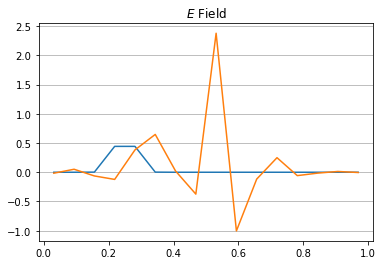

In [14]:
plt.figure()
plt.plot(xCell, E0)
plt.plot(xCell, E)
plt.title(r'$E$ Field')
plt.grid(True, axis = 'y', zorder = 0)
plt.show()

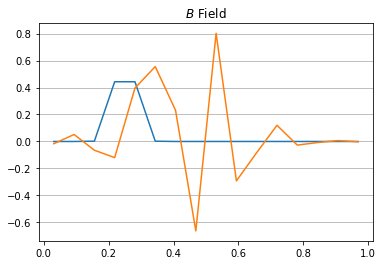

In [15]:
plt.figure()
plt.plot(xCell, B0)
plt.plot(xCell, B)
plt.title(r'$B$ Field')
plt.grid(True, axis = 'y', zorder = 0)
plt.show()

In [16]:
## Calculate the RHS for E,B in Maxwell's equations using 5th-order upwind
# def calcRHSUpwind5(E, B, c1, c2, N, dx):

# Fill in ghost cells for left, right domain - need 3 for up5
P = 5 # 5th-order interpolant
Ng = 3 # 3 ghost cells for this stencil
Eg1, Eg2 = ghostCellsJump(E,dx,N,Ng,P)
Bg1, Bg2 = ghostCellsJump(B,dx,N,Ng,P)

# Transform to the computational vars w/ eigen xform
ix1 = np.arange(int(N/2))
E1 = np.append(E[ix1], Eg1) # with ghost cell values at the jump
B1 = np.append(B[ix1], Bg1)
phil1 = .5*(E1-c1*B1) # characteristic variable
phir1 = .5*(E1+c1*B1)
ix2 = int(N/2)+np.arange(int(N/2))
E2 = np.append(Eg2, E[ix2]) # with ghost cell values at the jump
B2 = np.append(Bg2, B[ix2])
phil2 = .5*(E2-c2*B2)
phir2 = .5*(E2+c2*B2)

# Regular Face stencil from cell-averages - upwind for right-moving
# [2 -13 47 | 27 -3]/60
sr = np.asarray([2, -13, 47, 27, -3])/60
Ni = int(N/2+2*Ng) #  +3 ghost cells either side
print(Ni)
# Ur = spdiags(ones(Ni,1)*sr,[0:4],N/2+1,Ni)
# sl = fliplr(sr);
# Ul = spdiags(ones(Ni,1)*sl,[1:5],N/2+1,Ni);

# % Face values from upwind (index 1:N for faces left of cell + 1 for mat)
# phil1f = Ul*[phil1(1)*ones(3,1); phil1]; % outflow bc's on left
# phir1f = Ur*[zeros(3,1); phir1]; % 0 at leftmost face for inflow boundary conditions
# phil2f = Ul*[phil2; zeros(3,1)]; % 0 at rightmost face for inflow boundary conditions
# phir2f = Ur*[phir2; phir2(N/2+Ng)*ones(3,1)];  % outflow bc's on right

# % Correct values at material interface with jump conditions
# ix = N/2+1;
# T1 = 2*c1/(c1+c2);
# R1 = (c2-c1)/(c1+c2);
# phil1f(ix) = T1*phil2f(1) + R1*phir1f(ix);
# T2 = 2*c2/(c1+c2);
# R2 = (c1-c2)/(c1+c2);
# phir2f(1) = R2*phil2f(1) + T2*phir1f(ix);

# % Transform back to E,B on faces
# E1f = phil1f + phir1f;
# B1f = (-phil1f + phir1f)/c1;
# E2f = phil2f + phir2f;
# B2f = (-phil2f + phir2f)/c2;

# % Calculate the RHS for E, B
# ixf = 2:N/2+1;
# rhsE = [-c1^2*(B1f(ixf) - B1f(ixf-1))/dx; -c2^2*(B2f(ixf) - B2f(ixf-1))/dx];
# rhsB = [-1*(E1f(ixf) - E1f(ixf-1))/dx; -1*(E2f(ixf) - E2f(ixf-1))/dx];

# return rhsE, rhsB
print('')

14

